#### Begin by exploring the instructor's notebook that introduces the application of **Random Fourier Features (RFF)** for image reconstruction. Demonstrate the following applications using the cropped image from the notebook: <br>**Superresolution**: perform superresolution on the image shown in notebook to enhance its resolution by factor **2**. Show a qualitative comparison of original and reconstructed image. [2 Marks]

Importing Libraries

In [1]:
import torch
import torchvision
import torchviz
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

Helper Functions

In [2]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [17]:
# create RFF features
def create_rff_features(X, num_features, gamma, random_state):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=gamma, random_state=random_state) # gamma  = 1/(2 * sigma**2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [3]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [46]:
def plot_reconstructed_and_original_image(original_img, net, X, title="", scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples* scale**2, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Get the image

In [4]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [5]:
# Read in a image from torchvision
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


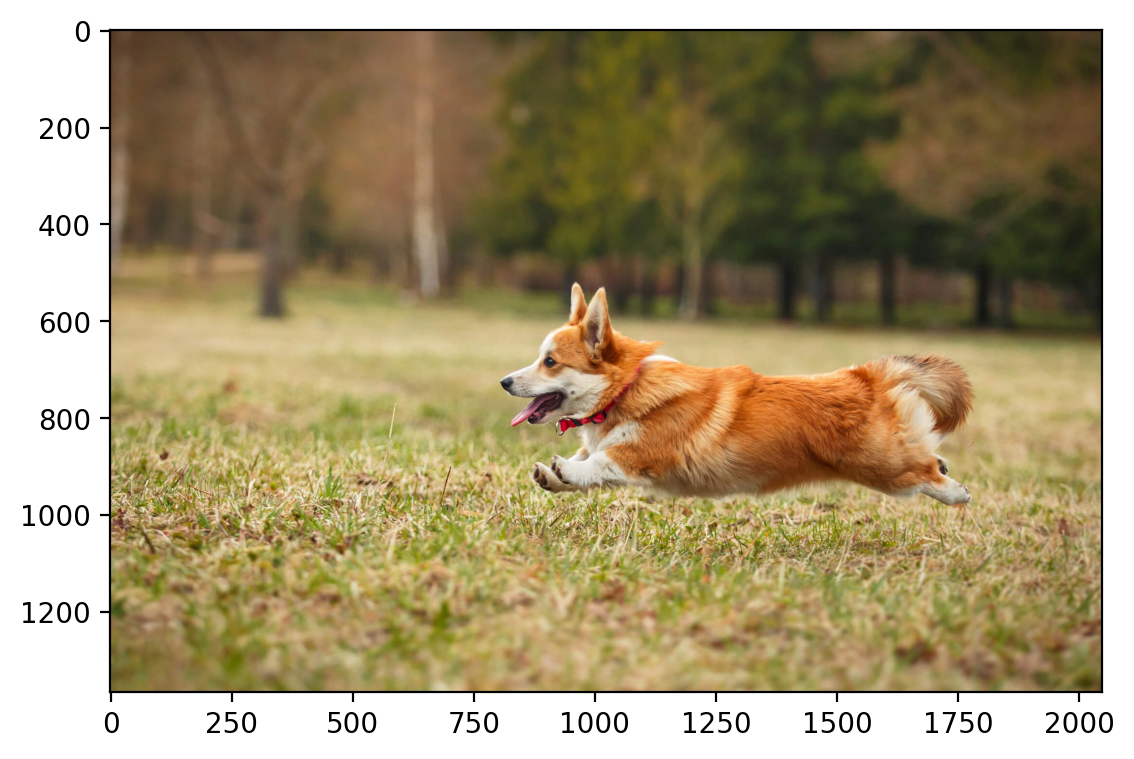

In [6]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

Processing the image

In [7]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape, img_scaled

(torch.Size([3, 1365, 2048]),
 tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          ...,
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],
 
         [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          ...,
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],
 
         [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          

torch.Size([3, 220, 220])


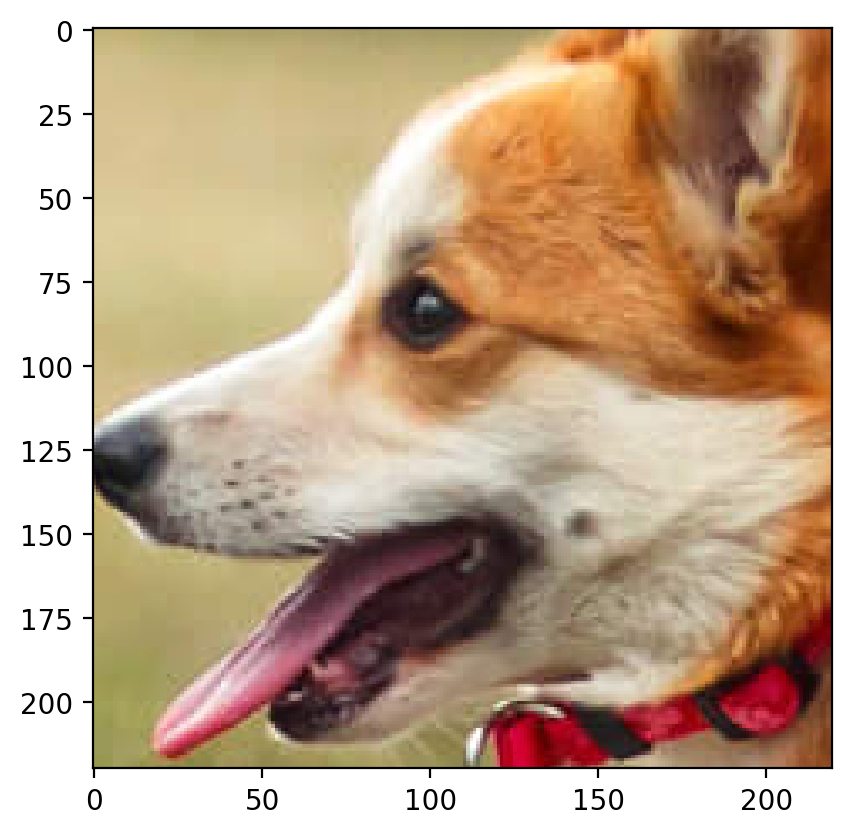

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 810, 220, 220)
crop = crop.to(device)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
scale = 1 # Resolution of the reconstructed image as compared to that of original image
dog_X, dog_Y = create_coordinate_map(crop, scale=scale)
dog_X.shape, dog_Y.shape # dog_X has coordinates of the image while dog_Y has channel values at the corresponding coordinates. 

(torch.Size([48400, 2]), torch.Size([48400, 3]))

In [10]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu()) # MinMaxScaler on dog_X from -1 to 1
dog_X_scaled = scaler_X.transform(dog_X.cpu()) # Scale the coordinates
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled.shape, dog_X_scaled[:10, :] # First 10 entries of dog_X scaled by MinMaxScaler from -1 to 1

(torch.Size([48400, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9909],
         [-1.0000, -0.9817],
         [-1.0000, -0.9726],
         [-1.0000, -0.9635],
         [-1.0000, -0.9543],
         [-1.0000, -0.9452],
         [-1.0000, -0.9361],
         [-1.0000, -0.9269],
         [-1.0000, -0.9178]]))

Defining the model class<br>
Model Used: _Fully Connected Neural Network_

In [11]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features): # Neural Network has "in_features" number of input features and "out_features" number of output features.   
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

!['NN.png'](NN.png)

Generating Random Fourier Features

In [37]:
X_rff = create_rff_features(dog_X_scaled, 3000, 'scale', random_state = 42) # num_of_features = 1000, gamma = 0.008

In [38]:
X_rff, X_rff.shape

(tensor([[-0.0043, -0.0257,  0.0002,  ...,  0.0191, -0.0233,  0.0024],
         [-0.0050, -0.0257,  0.0003,  ...,  0.0188, -0.0233,  0.0029],
         [-0.0058, -0.0256,  0.0005,  ...,  0.0184, -0.0234,  0.0034],
         ...,
         [ 0.0250,  0.0241, -0.0188,  ..., -0.0250,  0.0173, -0.0257],
         [ 0.0247,  0.0240, -0.0186,  ..., -0.0252,  0.0174, -0.0258],
         [ 0.0245,  0.0238, -0.0185,  ..., -0.0253,  0.0175, -0.0258]]),
 torch.Size([48400, 3000]))

Training 

In [39]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=3000, out_features=3, bias=True)
)

In [40]:
train(net, 0.005, X_rff, dog_Y, 2000)

Epoch 0 loss: 0.371391
Epoch 100 loss: 0.023636
Epoch 200 loss: 0.022783
Epoch 300 loss: 0.022387
Epoch 400 loss: 0.022127
Epoch 500 loss: 0.021924
Epoch 600 loss: 0.021749
Epoch 700 loss: 0.021587
Epoch 800 loss: 0.021433
Epoch 900 loss: 0.021285
Epoch 1000 loss: 0.021142
Epoch 1100 loss: 0.021003
Epoch 1200 loss: 0.020869
Epoch 1300 loss: 0.020739
Epoch 1400 loss: 0.020614
Epoch 1500 loss: 0.020492
Epoch 1600 loss: 0.020376
Epoch 1700 loss: 0.020263
Epoch 1800 loss: 0.020155
Epoch 1900 loss: 0.020050


0.019950831308960915

Creating super-resolved coordinate map

In [44]:
scale = 2
X2,Y2 = create_coordinate_map(crop, scale)
X2, Y2, X2.shape, Y2.shape

(tensor([[  0.0000,   0.0000],
         [  0.0000,   0.5000],
         [  0.0000,   1.0000],
         ...,
         [219.5000, 218.5000],
         [219.5000, 219.0000],
         [219.5000, 219.5000]]),
 tensor([[0.7608, 0.7020, 0.4784],
         [0.7608, 0.7020, 0.4784],
         [0.7608, 0.7020, 0.4784],
         ...,
         [0.5686, 0.3137, 0.1490],
         [0.5608, 0.3059, 0.1490],
         [0.5804, 0.3255, 0.1765]]),
 torch.Size([193600, 2]),
 torch.Size([48400, 3]))

In [47]:
scaler_X2 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X2.cpu())
X2_scaled = scaler_X2.transform(X2.cpu()) # Scale the coordinates
X2_scaled = torch.tensor(X2_scaled).to(device)
X2_scaled = X2_scaled.float()
X2_scaled.shape, X2_scaled[:10, :] # First 10 entries of dog_X scaled by MinMaxScaler from -1 to 1

(torch.Size([193600, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9954],
         [-1.0000, -0.9909],
         [-1.0000, -0.9863],
         [-1.0000, -0.9818],
         [-1.0000, -0.9772],
         [-1.0000, -0.9727],
         [-1.0000, -0.9681],
         [-1.0000, -0.9636],
         [-1.0000, -0.9590]]))

Generate RFF for scaled coordinate map

In [48]:
X_rff2 = create_rff_features(X2_scaled, 3000, 'scale', random_state = 42) # num_of_features = 1000, gamma = 0.008

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


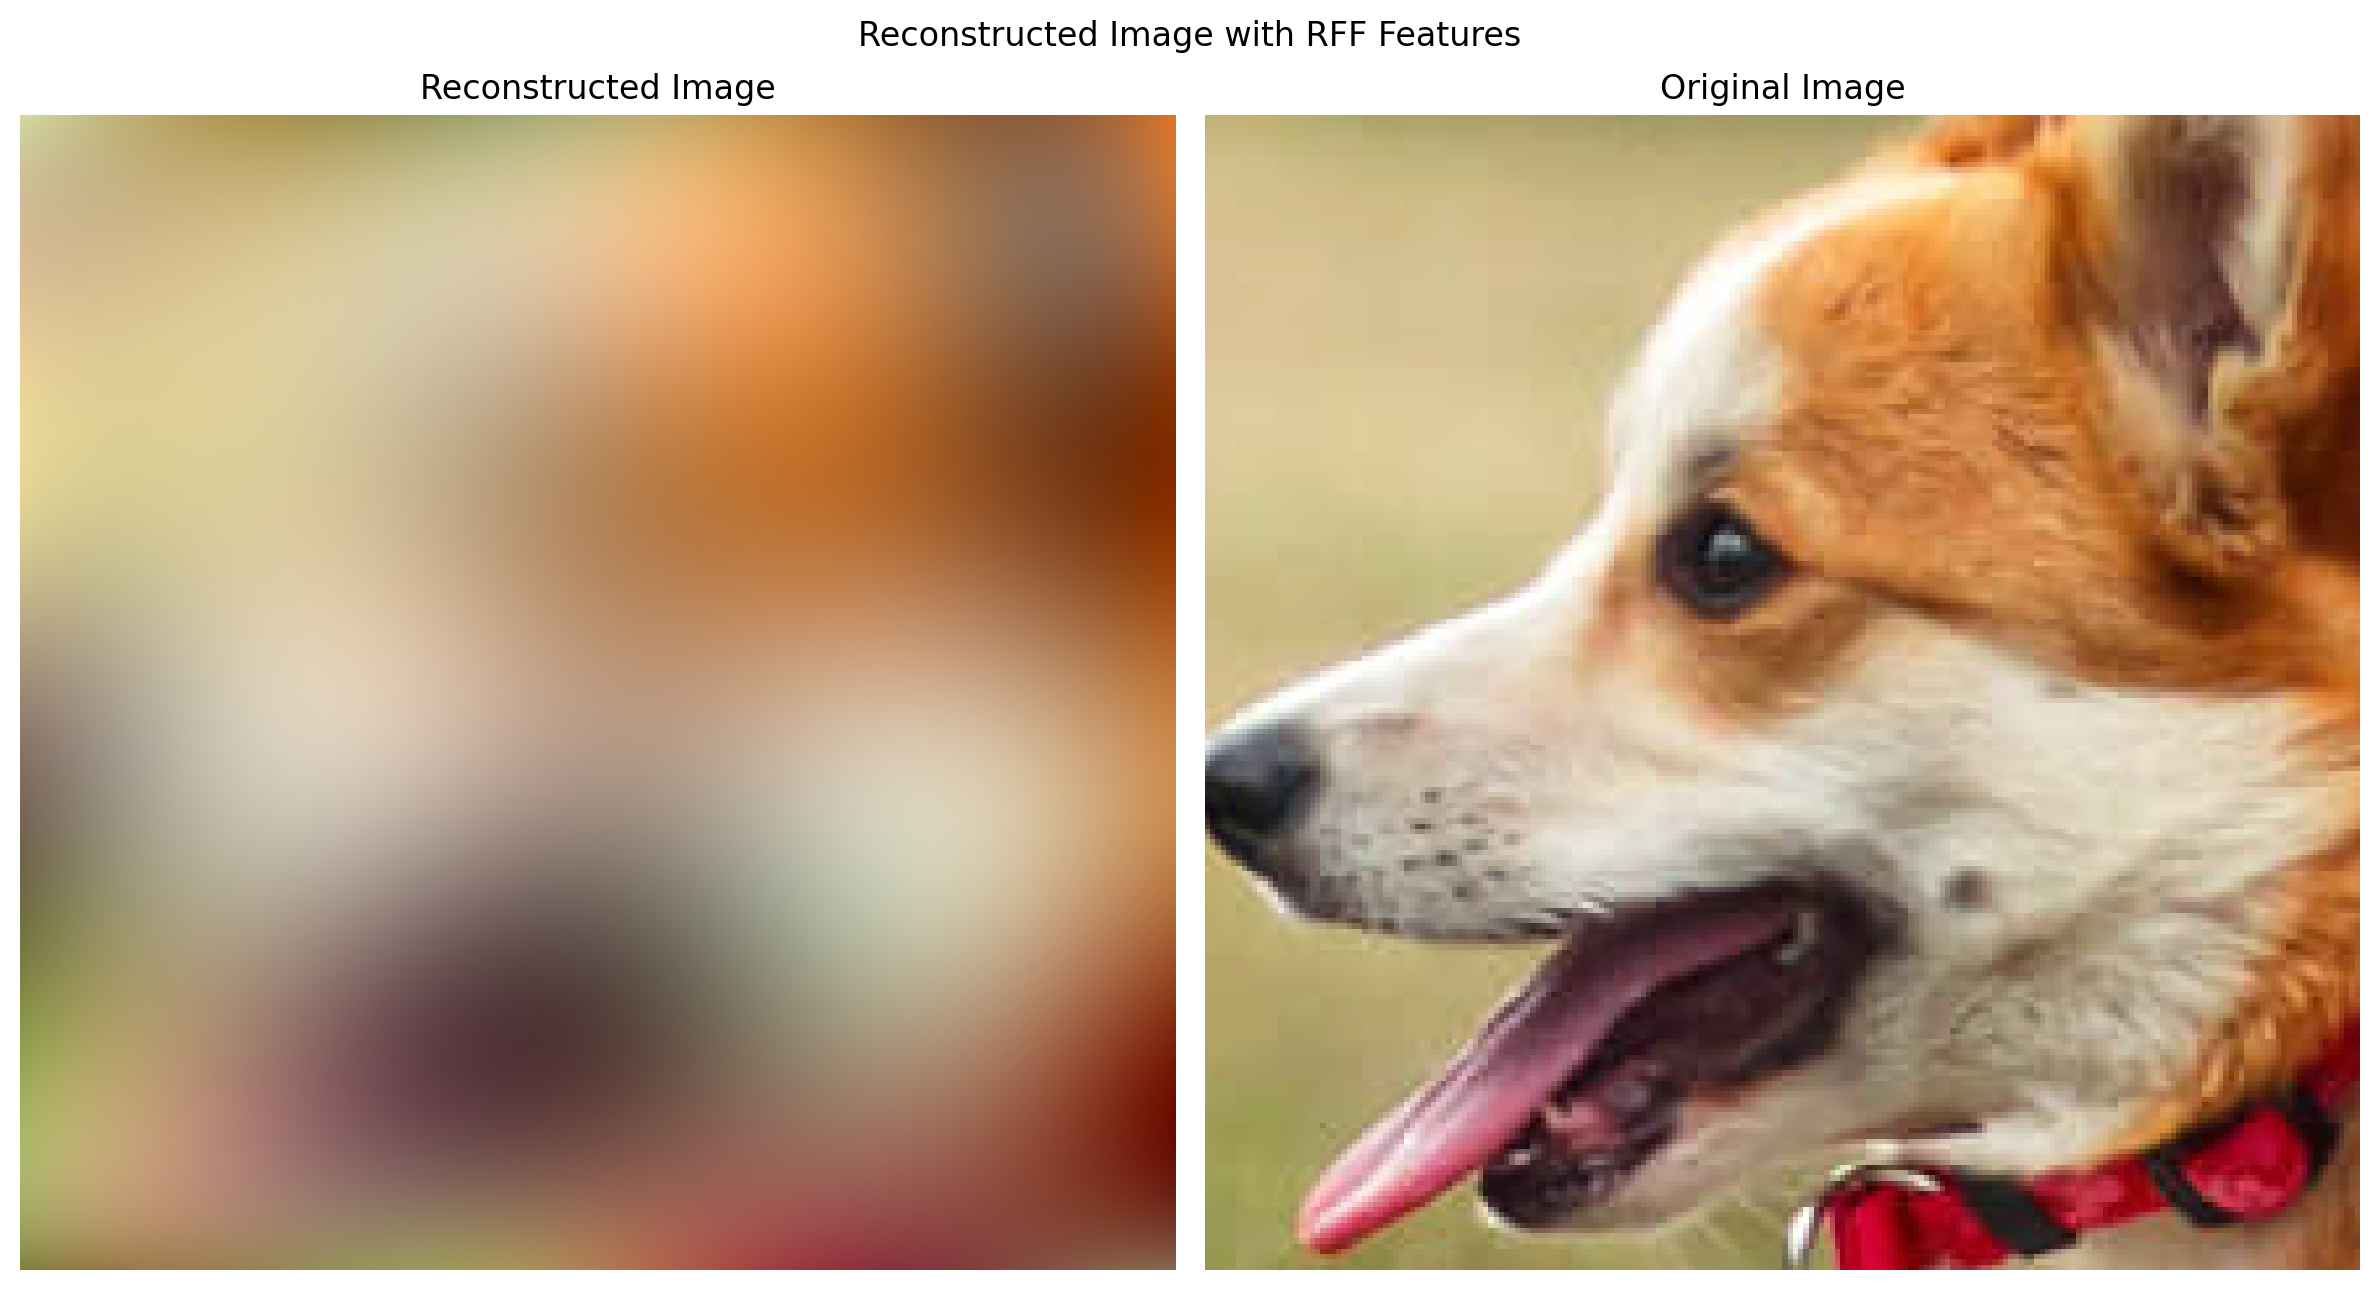

In [50]:
plot_reconstructed_and_original_image(crop, net, X_rff2,'Reconstructed Image with RFF Features', scale=2)